In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from PIL import Image
import math
import itertools

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import torch.nn.functional as F

from itertools import count
from collections import defaultdict

import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE

In [10]:
USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 100
z_dim = 128
test_path = '/home/irfandw/Works/dataset/morph/image_1/'

In [11]:
#Load test
test_dataset = ImageFolder(
        root=test_path,
        transform=torchvision.transforms.ToTensor()
    )
test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [4]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

In [5]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [6]:
class AE(nn.Module):
    def __init__(self, z_dim=10, nc=3):
        super(AE, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 128, 4, 2, 1, bias=False),              
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),             
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),             
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),           
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            View((-1, 1024*4*4)),                                 
            nn.Linear(1024*4*4, z_dim)                            
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 1024*8*8),                           
            View((-1, 1024, 8, 8)),                               
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),    
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),    
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, nc, 1),                       
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)

        return x_recon, z

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)

In [7]:
AE_net = AE(z_dim=128, nc=3)

if torch.cuda.is_available():
    AE_net = AE_net.cuda()

AE_net.load_state_dict(torch.load('saved_model_x3/AE.pth'))

/home/irfandw/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  This is separate from the ipykernel package so we can avoid doing imports until


## Autoencoder part

In [12]:
AE_net.eval()

recons_images = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = AE_net._encode(datax)
        decod = AE_net._decode(z_encoded)

        recons_images.append(decod[0].cpu().numpy())

recons_images = np.array(recons_images)
recons_images = np.transpose(recons_images, (0, 2,3,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


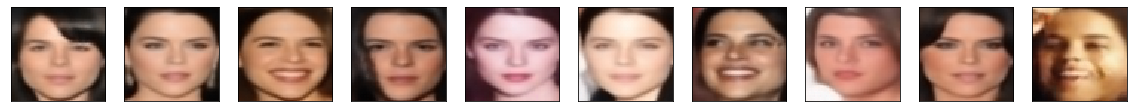

In [13]:
plt.figure(figsize=(20, 4))


for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(recons_images[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #plt.savefig('result/01-wae_128_recons_1.jpg', dpi=300, bbox_inches = 'tight')


## Morph

In [14]:
path_image1 = '/home/irfandw/Works/dataset/morph/image_1/'

path_image2 = '/home/irfandw/Works/dataset/morph/image_2/'


test_dataset1 = ImageFolder(
        root=path_image1,
        transform=torchvision.transforms.ToTensor()
    )
test_loader1 = DataLoader(
        test_dataset1,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )


test_dataset2 = ImageFolder(
        root=path_image2,
        transform=torchvision.transforms.ToTensor()
    )
test_loader2 = DataLoader(
        test_dataset2,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [15]:
AE_net.eval()


z1 = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader1):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = AE_net._encode(datax)
        z1.append(z_encoded[0].cpu().numpy())

z1 = np.array(z1)

In [16]:
AE_net.eval()

z2 = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader2):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = AE_net._encode(datax)
        z2.append(z_encoded[0].cpu().numpy())

z2 = np.array(z2)

In [17]:
AE_net.eval()

d_morph = []

with torch.no_grad():
    for i,a in enumerate(np.linspace(0,1,10)):
        z_new = z1[0] * (1. - a) + z2[3] * a
        
        zx = torch.from_numpy(z_new)
        zx = zx.to(device)
        
        gen = AE_net._decode(zx)

        d_morph.append(gen[0].cpu().numpy())

d_morph = np.array(d_morph)
d_morph = np.transpose(d_morph, (0, 2,3,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


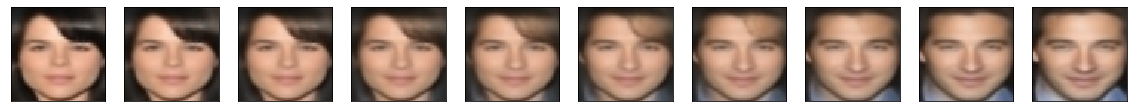

In [18]:
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(d_morph[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #plt.savefig('result/03-morph_wae_128.jpg', dpi=300, bbox_inches = 'tight')

## TSNE

In [19]:
tsne_path = '/home/irfandw/Works/dataset/tsne/'

In [20]:
tsne_dataset = ImageFolder(
        root=tsne_path,
        transform=torchvision.transforms.ToTensor()
    )
tsne_loader = DataLoader(
        tsne_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [21]:
def load_name(path):
    all_names = []
    all_index =  []    
    
    for root, dirs, files in os.walk(path):
        all_index.append(os.path.basename(root))
        dirs.sort()
        for file_ in files:
            all_names.append(os.path.basename(root))
                
    return all_names, all_index

all_names, indexing = load_name(tsne_path)

In [22]:
all_names

['Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',


In [23]:
d = defaultdict(count().__next__)

new_list = [d[x] for x in all_names]

new_list =  np.array(new_list)

In [24]:
AE_net.eval()

z_tsne = []

with torch.no_grad():
    for batch_idx, data in enumerate(tsne_loader):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = AE_net._encode(datax)
        z_tsne.append(z_encoded[0].cpu().numpy())

z_tsne = np.array(z_tsne)

In [25]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=30, n_iter=2000)

In [26]:
X_2d = tsne.fit_transform(z_tsne)

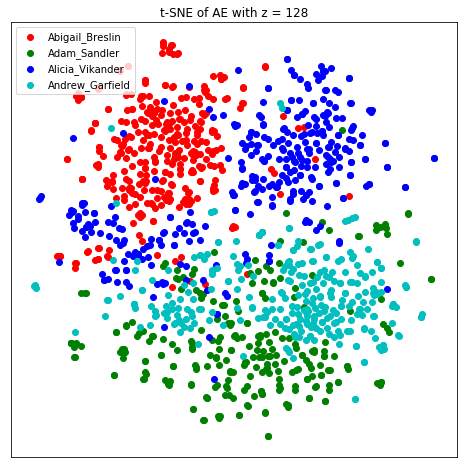

In [27]:
target_ids = range(len(indexing[1:]))

plt.figure(figsize=(8,8))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'brown', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, indexing[1:]):
    plt.scatter(X_2d[new_list == i, 0], X_2d[new_list == i, 1], c=c, label=label)


plt.title('t-SNE of AE with z = 128')      
plt.xticks([], [])
plt.yticks([], [])
plt.legend(loc="upper left")
#plt.savefig('result/04-AE_128_TSNE.jpg', dpi=300, bbox_inches = 'tight')
plt.show()